In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras as keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf 

# Set the random seed to be sure that results are reproducible
np.random.seed(25)
tf.random.set_seed(25)

# Load the data
data = pd.read_csv("Load_data_new.csv")
data["Time"] = pd.to_datetime(data["Time"])
data.set_index("Time", inplace=True)

# Replace textual descriptions with numerical values
replacement_dict = {
    "no clouds": 0,
    "2/10–3/10.": 3,
    "7/10 – 8/10.": 8,
    "10/10.": 10,
    "4/10.": 4,
    "5/10.": 5,
    "Sky obscured by fog and/or other meteorological phenomena.": 10,
}
data['total_cloud_cover[from ten]'] = data['total_cloud_cover[from ten]'].replace(replacement_dict).astype('float64')

# Create new features for time-related variables
data['hour'] = data.index.hour
data['day_of_year'] = data.index.dayofyear
data['day_of_month'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year

# Create lag features
num_lags = 3
for i in range(1, num_lags+1):
    data[f'electricity_consumption_lag_{i}'] = data['electricity_demand_values[kw]'].shift(i)
    data[f'heat_consumption_lag_{i}'] = data['heat_demand_values[kw]'].shift(i)

# Rolling window statistics
data['electricity_rolling_mean'] = data['electricity_demand_values[kw]'].rolling(window=3).mean()
data['heat_rolling_mean'] = data['heat_demand_values[kw]'].rolling(window=3).mean()

# Remove rows with NaN values
data = data.dropna()

# Save the preprocessed data
data.to_csv("preprocessed_data1.csv", index=True) 

In [2]:
# Normalize the data
data = data.reset_index()
data = data.drop(columns=["Time"])
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data)

In [4]:
#Split the dataset into training, validation, and testing sets
train_size = int(len(data_norm) * 0.6)
val_size = int(len(data_norm) * 0.2)
test_size = len(data_norm) - train_size - val_size
train, val, test = data_norm[:train_size, :], data_norm[train_size:train_size+val_size, :], data_norm[train_size+val_size:, :]

In [13]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), :-2])
        dataY.append(dataset[i + look_back, -2:])
    return np.array(dataX), np.array(dataY)

In [12]:
# Generate input and output data
look_back = 24
X_train, y_train = create_dataset(train, look_back)
X_val, y_val = create_dataset(val, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape the input data from 3D to 2D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [42]:
# Define the MLP model with increased complexity, regularization, and batch normalization
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(2)
])
# Learning rate schedule
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        lr *= 0.9
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)
# EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Epoch 1/200
573/573 - 3s - loss: 1.0443 - val_loss: 0.4895 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 2/200
573/573 - 2s - loss: 0.4403 - val_loss: 0.3711 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 3/200
573/573 - 2s - loss: 0.3150 - val_loss: 0.2554 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 4/200
573/573 - 2s - loss: 0.2082 - val_loss: 0.1591 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 5/200
573/573 - 2s - loss: 0.1242 - val_loss: 0.0907 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 6/200
573/573 - 2s - loss: 0.0663 - val_loss: 0.0473 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 7/200
573/573 - 2s - loss: 0.0318 - val_loss: 0.0195 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 8/200
573/573 - 2s - loss: 0.0145 - val_loss: 0.0081 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 9/200
573/573 - 2s - loss: 0.0074 - val_loss: 0.0044 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 10/200
573/573 - 2s - loss: 0.0052 - val_loss: 0.0031 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 11/200
573/573 - 2s - loss: 0.0046 - val_loss: 0.0039

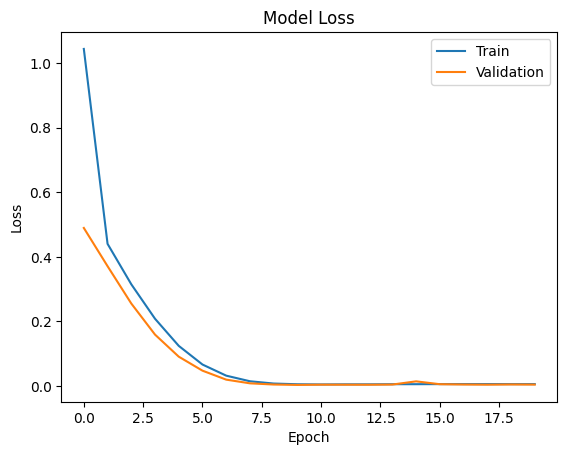

In [43]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=72, validation_data=(X_val, y_val), verbose=2, callbacks=[lr_callback, early_stopping])
# Plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [44]:
# Evaluate and make predictions
y_pred = model.predict(X_test)
# Calculate metrics
rmse_electricity = np.sqrt(mean_squared_error(y_test[:, 0], y_pred[:, 0]))
rmse_heat = np.sqrt(mean_squared_error(y_test[:, 1], y_pred[:, 1]))
print(f"RMSE for electricity demand: {rmse_electricity}")
print(f"RMSE for heat demand: {rmse_heat}")
mae_electricity = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_heat = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_electricity = r2_score(y_test[:, 0], y_pred[:, 0])
r2_heat = r2_score(y_test[:, 1], y_pred[:, 1])
print(f"R-squared for electricity demand: {r2_electricity}")
print(f"R-squared for heat demand: {r2_heat}")
print(f"MAE for electricity demand: {mae_electricity}")
print(f"MAE for heat demand: {mae_heat}")

430/430 [==============================] - 1s 1ms/step
RMSE for electricity demand: 0.04404736503301645
RMSE for heat demand: 0.043252380869142196
R-squared for electricity demand: 0.934014239977478
R-squared for heat demand: 0.9557354715543233
MAE for electricity demand: 0.03627047362272598
MAE for heat demand: 0.03245755697734264


In [45]:
model.save("mlp_model.h5")

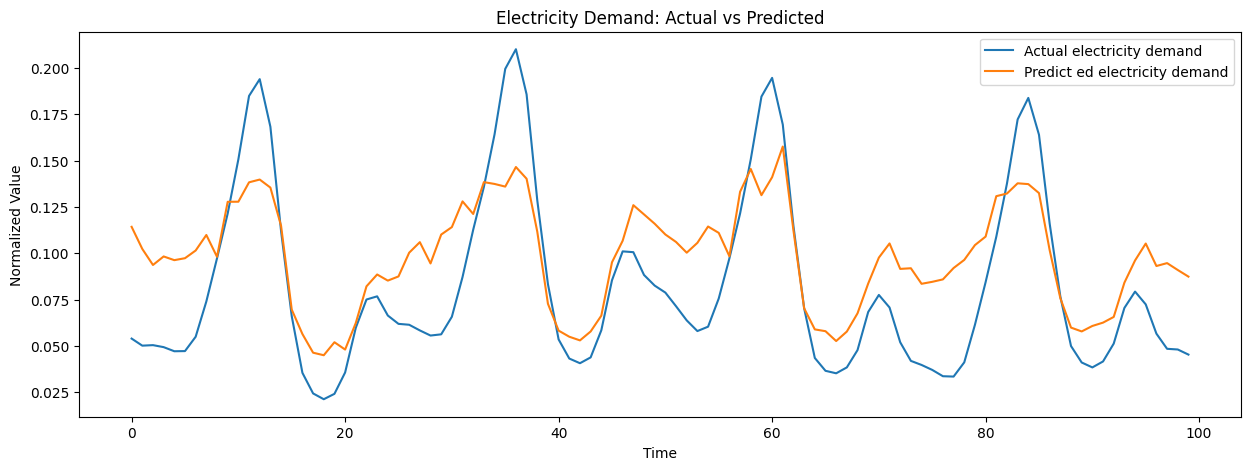

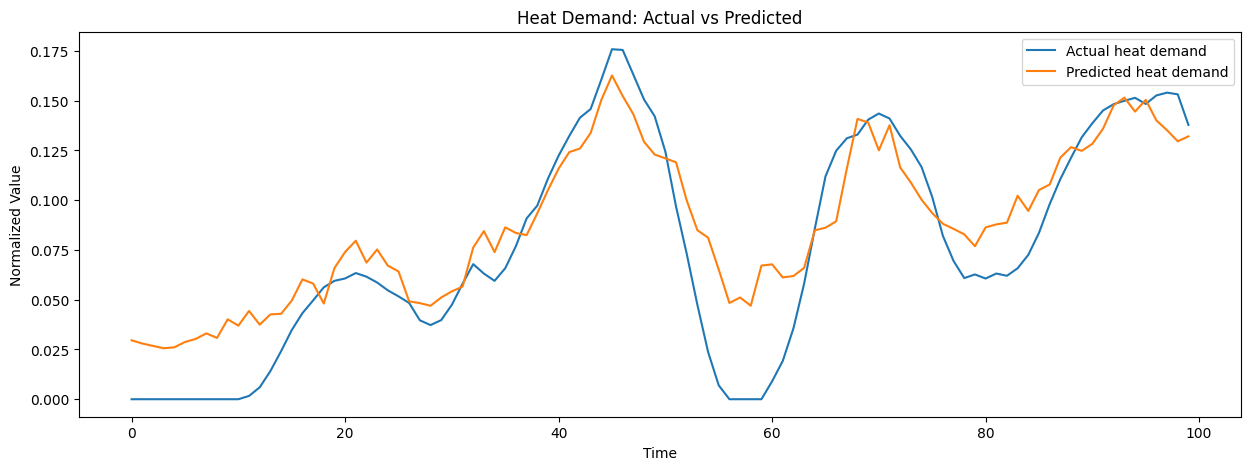

In [46]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test[:100, 0], label="Actual electricity demand")
plt.plot(y_pred[:100, 0], label="Predict ed electricity demand")
plt.title("Electricity Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:100, 1], label="Actual heat demand")
plt.plot(y_pred[:100, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

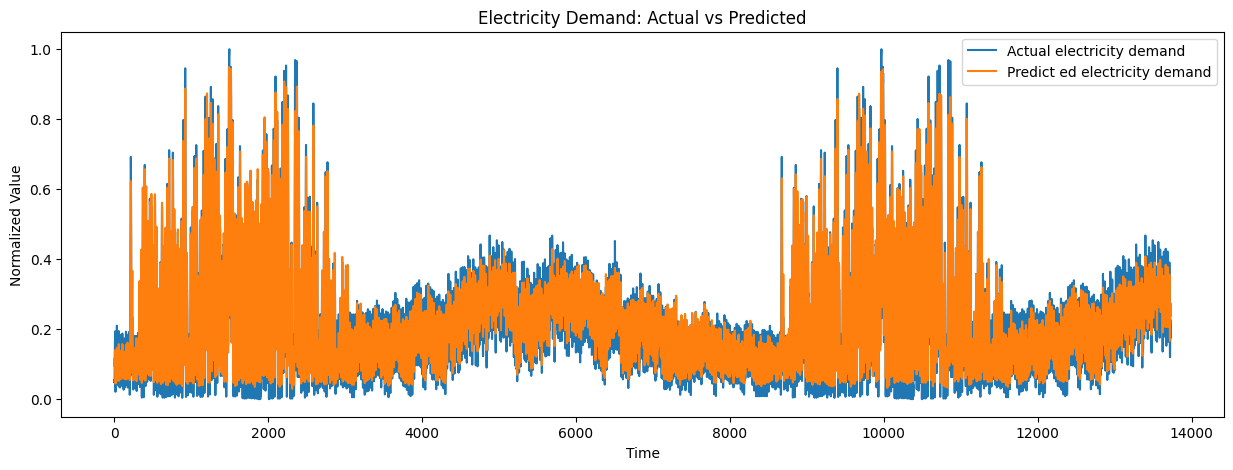

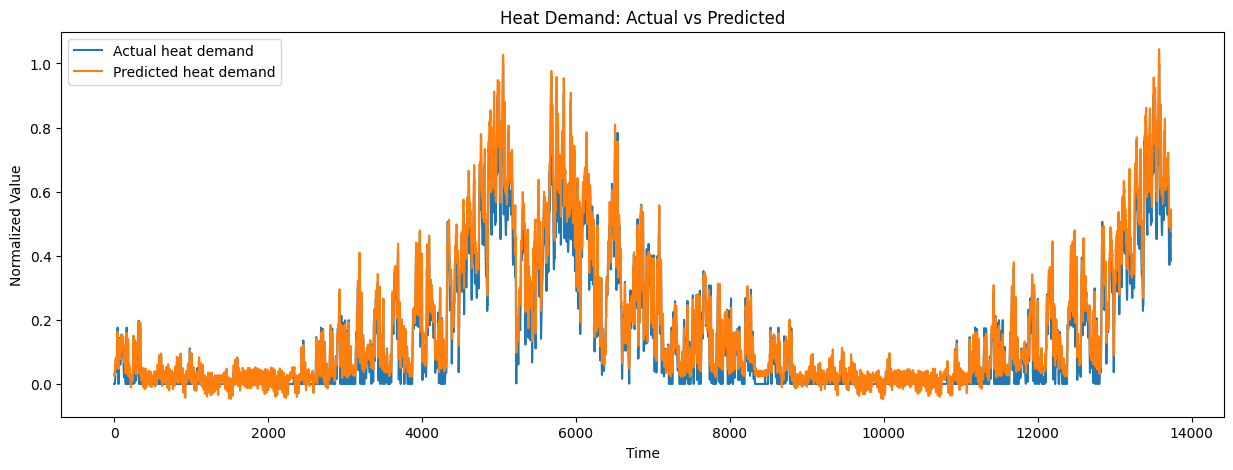

In [47]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test[:14000, 0], label="Actual electricity demand")
plt.plot(y_pred[:14000, 0], label="Predict ed electricity demand")
plt.title("Electricity Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:14000, 1], label="Actual heat demand")
plt.plot(y_pred[:14000, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

In [49]:
#Data denormalization
electricity_demand_idx = data.columns.get_loc("electricity_demand_values[kw]")
heat_demand_idx = data.columns.get_loc("heat_demand_values[kw]")
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(data.iloc[:, [electricity_demand_idx, heat_demand_idx]])
# Use the inverse_transform method to transform the predicted and actual values back to the original scale
y_test_denorm = target_scaler.inverse_transform(y_test)
y_pred_denorm = target_scaler.inverse_transform(y_pred)
# Now, y_test_denorm and y_pred_denorm contain the denormalized actual and predicted values, respectively.

Index 0: Actual [electricity, heat] = [192.82, 0.00], Predicted [electricity, heat] = [282.06, 45.26]
Index 1: Actual [electricity, heat] = [187.17, 0.00], Predicted [electricity, heat] = [264.41, 42.80]
Index 2: Actual [electricity, heat] = [187.59, 0.00], Predicted [electricity, heat] = [251.59, 40.98]
Index 3: Actual [electricity, heat] = [185.99, 0.00], Predicted [electricity, heat] = [258.41, 39.16]
Index 4: Actual [electricity, heat] = [182.71, 0.00], Predicted [electricity, heat] = [255.44, 39.89]
Index 5: Actual [electricity, heat] = [182.83, 0.00], Predicted [electricity, heat] = [257.01, 43.97]
Index 6: Actual [electricity, heat] = [194.29, 0.00], Predicted [electricity, heat] = [263.15, 46.33]
Index 7: Actual [electricity, heat] = [222.48, 0.00], Predicted [electricity, heat] = [275.54, 50.60]
Index 8: Actual [electricity, heat] = [256.94, 0.00], Predicted [electricity, heat] = [258.12, 47.09]
Index 9: Actual [electricity, heat] = [292.73, 0.00], Predicted [electricity, heat

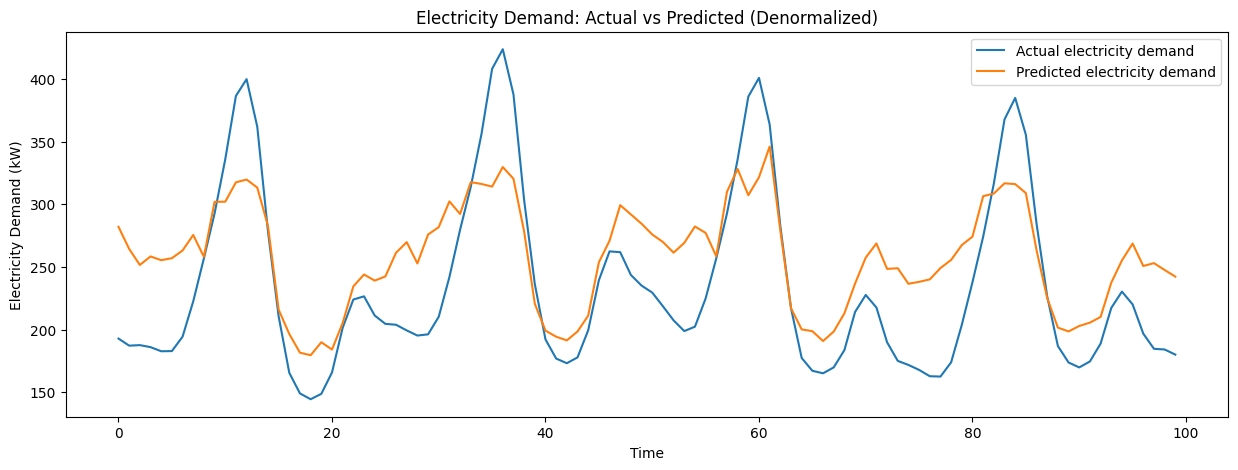

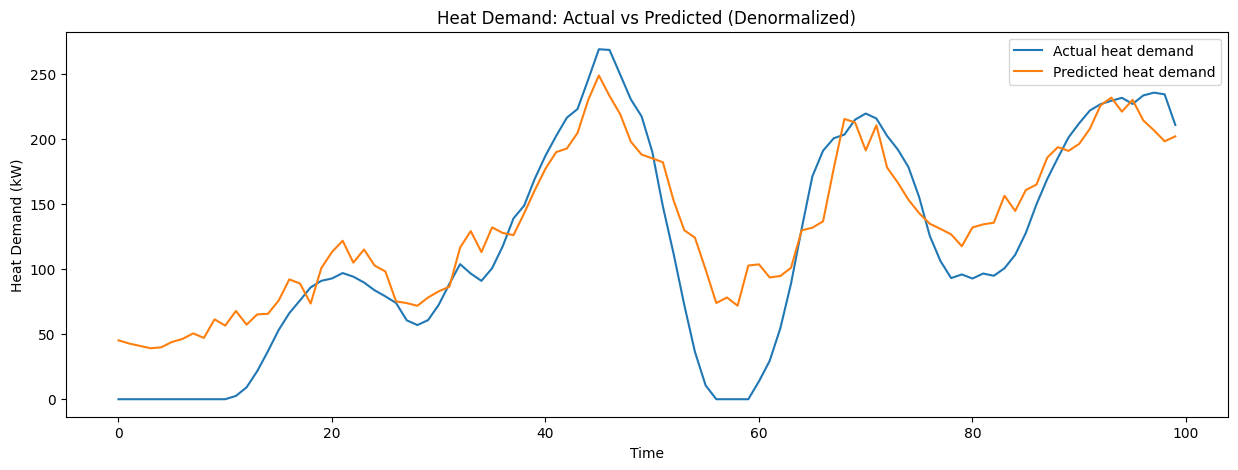

In [50]:
# Print some denormalized actual and predicted values for comparison
i_range = range(13731)
for i in i_range:
    print(f"Index {i}: Actual [electricity, heat] = [{y_test_denorm[i, 0]:.2f}, {y_test_denorm[i, 1]:.2f}], Predicted [electricity, heat] = [{y_pred_denorm[i, 0]:.2f}, {y_pred_denorm[i, 1]:.2f}]")
# Plot actual vs predicted values for denormalized data
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:100, 0], label="Actual electricity demand")
plt.plot(y_pred_denorm[:100, 0], label="Predicted electricity demand")
plt.title("Electricity Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Electricity Demand (kW)")
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:100, 1], label="Actual heat demand")
plt.plot(y_pred_denorm[:100, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Heat Demand (kW)")
plt.legend()
plt.show()


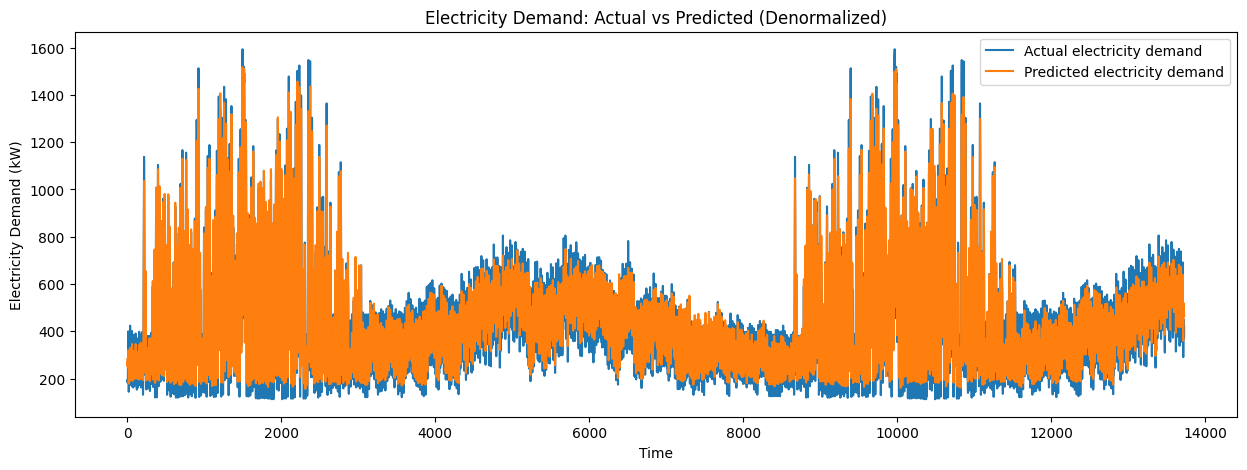

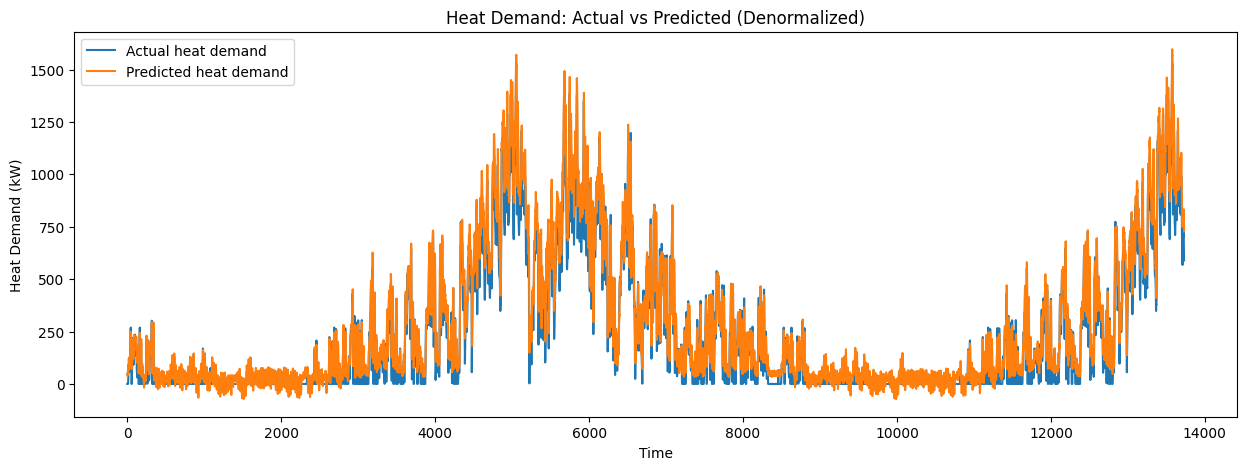

In [51]:
# Plot actual vs predicted values for denormalized data
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:14000, 0], label="Actual electricity demand")
plt.plot(y_pred_denorm[:14000, 0], label="Predicted electricity demand")
plt.title("Electricity Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Electricity Demand (kW)")
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:14000, 1], label="Actual heat demand")
plt.plot(y_pred_denorm[:14000, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Heat Demand (kW)")
plt.legend()
plt.show()